In [4]:
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
# Chemins des données
benign_path = "//kaggle/input/breastcancermasses/Dataset of Mammography with Benign Malignant Breast Masses/Dataset of Mammography with Benign Malignant Breast Masses/INbreast+MIAS+DDSM Dataset/Benign Masses"
malignant_path = "/kaggle/input/breastcancermasses/Dataset of Mammography with Benign Malignant Breast Masses/Dataset of Mammography with Benign Malignant Breast Masses/INbreast+MIAS+DDSM Dataset/Malignant Masses"






In [5]:
# Fonction pour charger et prétraiter les images
def get_file_paths_and_labels(directory, label):
    file_paths = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith((".png", ".jpg", ".jpeg"))]
    labels = [label] * len(file_paths)
    return file_paths, labels


In [6]:
# Charger les chemins et les labels
benign_file_paths, benign_labels = get_file_paths_and_labels(benign_path, 0)
malignant_file_paths, malignant_labels = get_file_paths_and_labels(malignant_path, 1)

In [7]:
# Fusionner les chemins et labels
file_paths = benign_file_paths + malignant_file_paths
labels = benign_labels + malignant_labels



In [8]:
# Diviser les données en train, validation et test
X_train, X_temp, y_train, y_temp = train_test_split(file_paths, labels, test_size=0.4, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)



In [9]:
# Fonction de prétraitement 
def preprocess_image(file_path, label):
    try:
        # Charger l'image
        img = tf.io.read_file(file_path)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.resize(img, [227, 227])
        img = img / 255.0
        return img, label
    except Exception as e:
        print(f"Erreur lors du traitement du fichier : {file_path}. Erreur : {e}")
        return tf.zeros([227, 227, 3]), label

# Créer un dataset 
def create_dataset(file_paths, labels, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(file_paths))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset




In [10]:
batch_size = 32
train_dataset = create_dataset(X_train, y_train, batch_size=batch_size)
val_dataset = create_dataset(X_val, y_val, batch_size=batch_size, shuffle=False)
test_dataset = create_dataset(X_test, y_test, batch_size=batch_size, shuffle=False)



In [11]:



# Charger ResNet50
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(227, 227, 3))

# Ajouter les couches de classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(1, activation="sigmoid")(x)
model = Model(inputs=base_model.input, outputs=predictions)


In [12]:

# Geler les couches de base
for layer in base_model.layers:
    layer.trainable = False

# Compiler le modèle
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Entraîner le modèle
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20
)




Epoch 1/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 111s 149ms/step - accuracy: 0.5443 - loss: 0.8014 - val_accuracy: 0.5626 - val_loss: 0.7784
Epoch 2/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 74s 141ms/step - accuracy: 0.5888 - loss: 0.6795 - val_accuracy: 0.6130 - val_loss: 0.6218
Epoch 3/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 74s 141ms/step - accuracy: 0.6335 - loss: 0.6384 - val_accuracy: 0.5913 - val_loss: 0.6231
Epoch 4/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 74s 140ms/step - accuracy: 0.6551 - loss: 0.6149 - val_accuracy: 0.6706 - val_loss: 0.5934
Epoch 5/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 74s 141ms/step - accuracy: 0.6950 - loss: 0.5832 - val_accuracy: 0.6395 - val_loss: 0.6318
Epoch 6/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 73s 140ms/step - accuracy: 0.6838 - loss: 0.5869 - val_accuracy: 0.7436 - val_loss: 0.5415
Epoch 7/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 74s 140ms/step - accuracy: 0.7019 - loss: 0.5670 - val_accuracy: 0.7349 - val_loss: 0.5569
Epoch 8/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 73s 141ms/step - accuracy: 0.7045 - loss: 

In [13]:
# Évaluer sur le dataset de test
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.2f}")



154/154 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - accuracy: 0.7551 - loss: 0.4949
Test Accuracy: 0.75


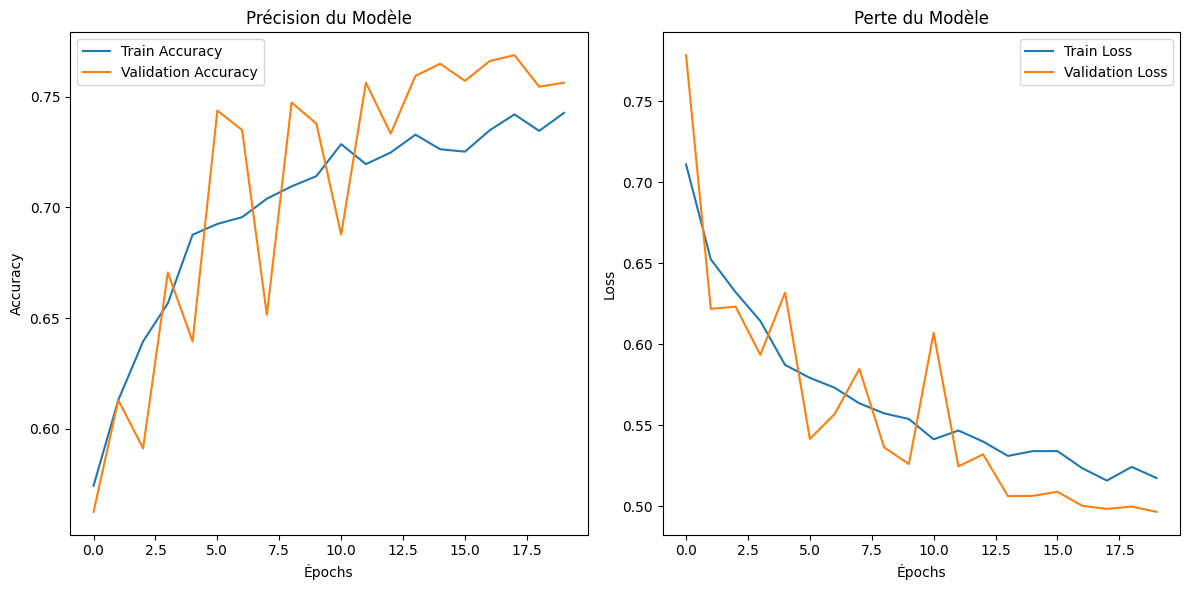

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━

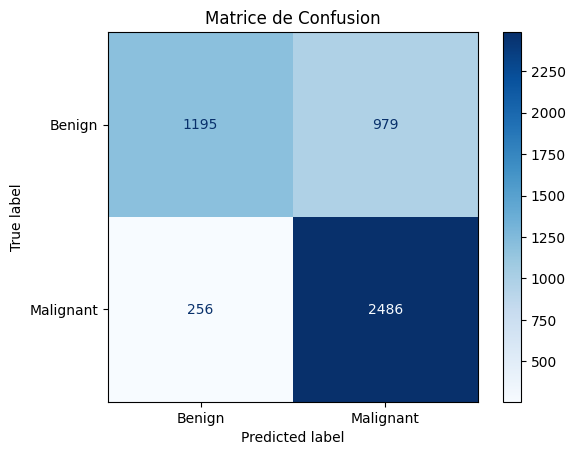

In [14]:

# 1. Afficher les courbes de précision et de perte
def plot_training_history(history):
    # Précision
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Précision du Modèle')
    plt.xlabel('Épochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Perte
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Perte du Modèle')
    plt.xlabel('Épochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 2. Calculer et afficher la matrice de confusion
def plot_confusion_matrix(model, test_dataset):
    # Prédictions et vrais labels
    y_true = []
    y_pred = []
    for images, labels in test_dataset:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.round(preds).flatten())  

    # Calcul de la matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Matrice de Confusion")
    plt.show()

plot_training_history(history)
plot_confusion_matrix(model, test_dataset)
